In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
import cv2

# image_dir="/content/drive/MyDrive/Biomedicine/AI Project 2024-2025/Train"
image_dir = "/kaggle/input/ds-lung-tumor/Train-20250104T155611Z-001/Train"

# Functions

In [2]:
def load_nrrd(file_path):
    try:
        image = sitk.ReadImage(file_path)
        array = sitk.GetArrayFromImage(image)
        return array
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_all_images():
    df_images = pd.read_excel("/kaggle/input/ds-lung-tumor/dataset_lung.xlsx") # Read the CSV file
    display(df_images)

    nodule_images = []
    full_images   = []
    labels        = []

    for index, row in df_images.iterrows():
        noduleslice_filename = row['Nodule']
        noduleslice_path        = os.path.join(image_dir, noduleslice_filename)
        noduleslice_image_array = load_nrrd(noduleslice_path)
        nodule_images.append(noduleslice_image_array)

        fullslice_filename = row['Full_slice']
        fullslice_path        = os.path.join(image_dir, fullslice_filename)
        fullslice_image_array = load_nrrd(fullslice_path)
        full_images.append(fullslice_image_array)
        
        label = row['TumorClass']
        labels.append(label)
   
    labels = np.array(labels)

    return full_images, nodule_images, labels

def gamma_transform(image, lower_bound, upper_bound, gamma):
    clipped_image    = np.clip(image, lower_bound, upper_bound)
    hu_min = np.min(clipped_image)
    hu_max = np.max(clipped_image)
    normalized_image = (clipped_image - hu_min) / (hu_max - hu_min) # Normalize to [0, 1]
    gamma_corrected  = np.power(normalized_image, gamma) # Apply gamma transformation
    gamma_corrected  = gamma_corrected * (hu_max - hu_min) + hu_min # Scale back to the original HU range
    return gamma_corrected

def plot_temp_images(images, labels_ids):
    fig, axes = plt.subplots(1, 7, figsize=(10, 3))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(images[idx], cmap='gray')  # Display image
        ax.set_title(str(labels[labels_ids[idx]]))
        ax.title.set_size(14)
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

def gamma_transform(image, gamma):
    hu_min = np.min(image)
    hu_max = np.max(image)
    normalized_image = (image - hu_min) / (hu_max - hu_min) # Normalize to [0, 1]
    gamma_corrected  = np.power(normalized_image, gamma) # Apply gamma transformation
    # gamma_corrected = (gamma_corrected * 255).astype(np.uint8) # Scale back to the original HU range
    gamma_corrected  = gamma_corrected * (hu_max - hu_min) + hu_min # Scale back to the original HU range
    return gamma_corrected
    
def plot_chunck_images(images, labels_ids):
    fig, axes = plt.subplots(3, 7, figsize=(12, 6))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(images[idx], cmap='gray')  # Display image
        ax.set_title(str(labels[labels_ids[idx]]))
        ax.title.set_size(14)
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

def plot_all_images(images, offset):
    if offset < 2300:
        fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    else:
        fig, axes = plt.subplots(7, 9, figsize=(18, 18))
    for idx, ax in enumerate(axes.flatten()):
        i = offset+idx
        ax.imshow(images[i], cmap='gray')  # Display image
        ax.set_title(str(i) + ' ==> ' + str(labels[i]))
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

# Load Dataset

In [3]:
full_images, nodule_images, labels = load_all_images()
df_images = pd.read_excel("/kaggle/input/ds-lung-tumor/dataset_lung.xlsx") # Read the CSV file
class_counts = df_images['TumorClass'].value_counts() # Return a Series containing the frequency of each distinct row in the Dataframe.
print("\nClass Distribution:")
print(class_counts)

,Full_slice,Nodule,TumorClass
0,pat1_fullslice.nrrd,pat1_nodule.nrrd,5
1,pat2_fullslice.nrrd,pat2_nodule.nrrd,5
2,pat3_fullslice.nrrd,pat3_nodule.nrrd,2
3,pat4_fullslice.nrrd,pat4_nodule.nrrd,5
4,pat5_fullslice.nrrd,pat5_nodule.nrrd,4
...,...,...,...
2358,pat2368_fullslice.nrrd,pat2368_nodule.nrrd,2
2359,pat2369_fullslice.nrrd,pat2369_nodule.nrrd,2
2360,pat2387_fullslice.nrrd,pat2387_nodule.nrrd,5
2361,pat2399_fullslice.nrrd,pat2399_nodule.nrrd,5



Class Distribution:
TumorClass
3    1092
2     457
4     418
1     244
5     152
Name: count, dtype: int64


In [4]:
min_hu = -1000
max_hu = +500
full_all_modified_slices = []
for img in full_images:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)

    full_all_modified_slices.append(temp_slice)

# Uncomment the lines below, if you want to see all the preprocessed images
# offsets = list(range(0, 2400, 100))
# for offset in offsets:
#     plot_all_images(full_all_modified_slices, offset)

In [5]:
min_hu = -1000
max_hu = +500
nodule_all_modified_slices = []
for img in nodule_images:

    # Mist reduction and gamma transformation
    temp_slice = np.clip(img, min_hu, max_hu)
    temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    temp_slice = np.uint8(temp_slice)
    temp_slice = clahe.apply(temp_slice)
    
    temp_slice = cv2.resize(temp_slice, (52, 52))

    nodule_all_modified_slices.append(temp_slice)

# Uncomment the lines below, if you want to see all the preprocessed images
# offsets = list(range(0, 2400, 100))
# for offset in offsets:
#     plot_all_images(nodule_all_modified_slices, offset)

# The Laplacian Variance Analysis

In [6]:
# Compute Laplacian variance for all images

laplacian_values_full = []
for img in full_all_modified_slices:
    # Compute Laplacian and its variance
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    laplacian_values_full.append(laplacian_var)
    
laplacian_values_nodule = []
for img in nodule_all_modified_slices:
    # Compute Laplacian and its variance
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    laplacian_values_nodule.append(laplacian_var)

In [12]:
# If you want to exclude more number of noisy images, decrease the value of laplacian_percentile
laplacian_percentile = 97

# Full Images
noisy_threshold_full = np.percentile(laplacian_values_full, laplacian_percentile)
noise_idx_full    = []
noise_image_full  = []
for idx, image in enumerate(full_all_modified_slices):
    lap_var = cv2.Laplacian(image, cv2.CV_64F).var()
    if lap_var > noisy_threshold_full:
        noise_idx_full.append(idx)
        noise_image_full.append(image)

preprocessed_full_slices = []
preprocessed_full_ids    = []
for idx, image in enumerate(full_all_modified_slices):
    if idx not in noise_idx_full:
        preprocessed_full_ids.append(idx)
        preprocessed_full_slices.append(image)
        

# Nodule Images
noisy_threshold_nodule = np.percentile(laplacian_values_nodule, laplacian_percentile)
noise_idx_nodule   = []
noise_image_nodule = []
for idx, image in enumerate(nodule_all_modified_slices):
    lap_var = cv2.Laplacian(image, cv2.CV_64F).var()
    if lap_var > noisy_threshold_nodule:
        noise_idx_nodule.append(idx)
        noise_image_nodule.append(image)

preprocessed_nodule_slices = []
preprocessed_nodule_ids    = []
for idx, image in enumerate(nodule_all_modified_slices):
    if idx not in noise_idx_nodule:
        preprocessed_nodule_ids.append(idx)
        preprocessed_nodule_slices.append(image)

# preprocessed_full_slices and preprocessed_nodule_slices contain preprocessed images
# preprocessed_full_ids and preprocessed_nodule_ids contain preprocessed images

IndexError: list index out of range

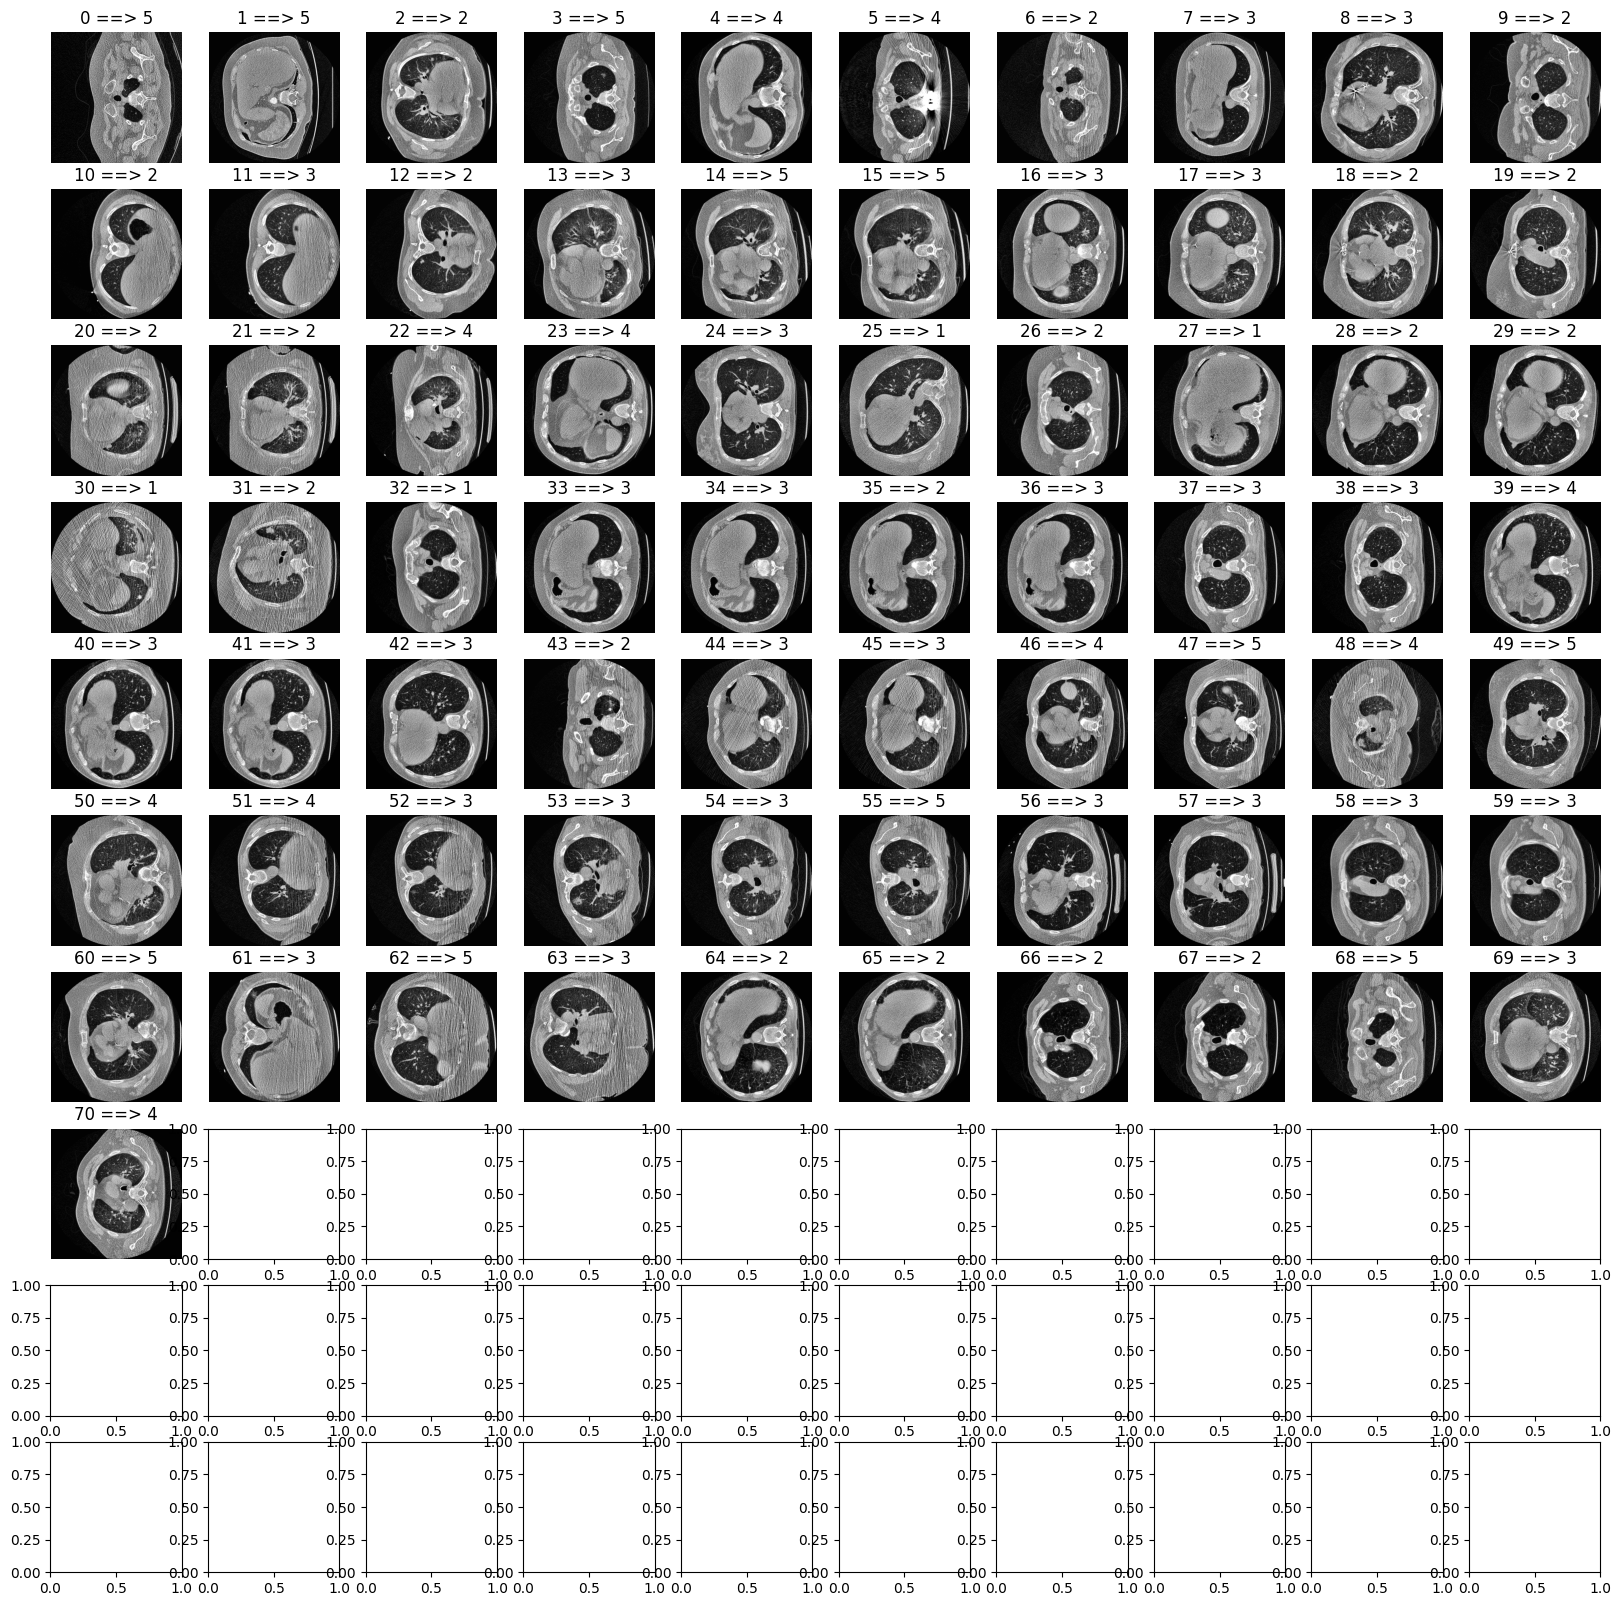

In [20]:
# If you want to see the full slice noisy images run this cell.
# It will raise a list index out of range error but it's OK.
plot_all_images(noise_image_full, 0)


IndexError: list index out of range

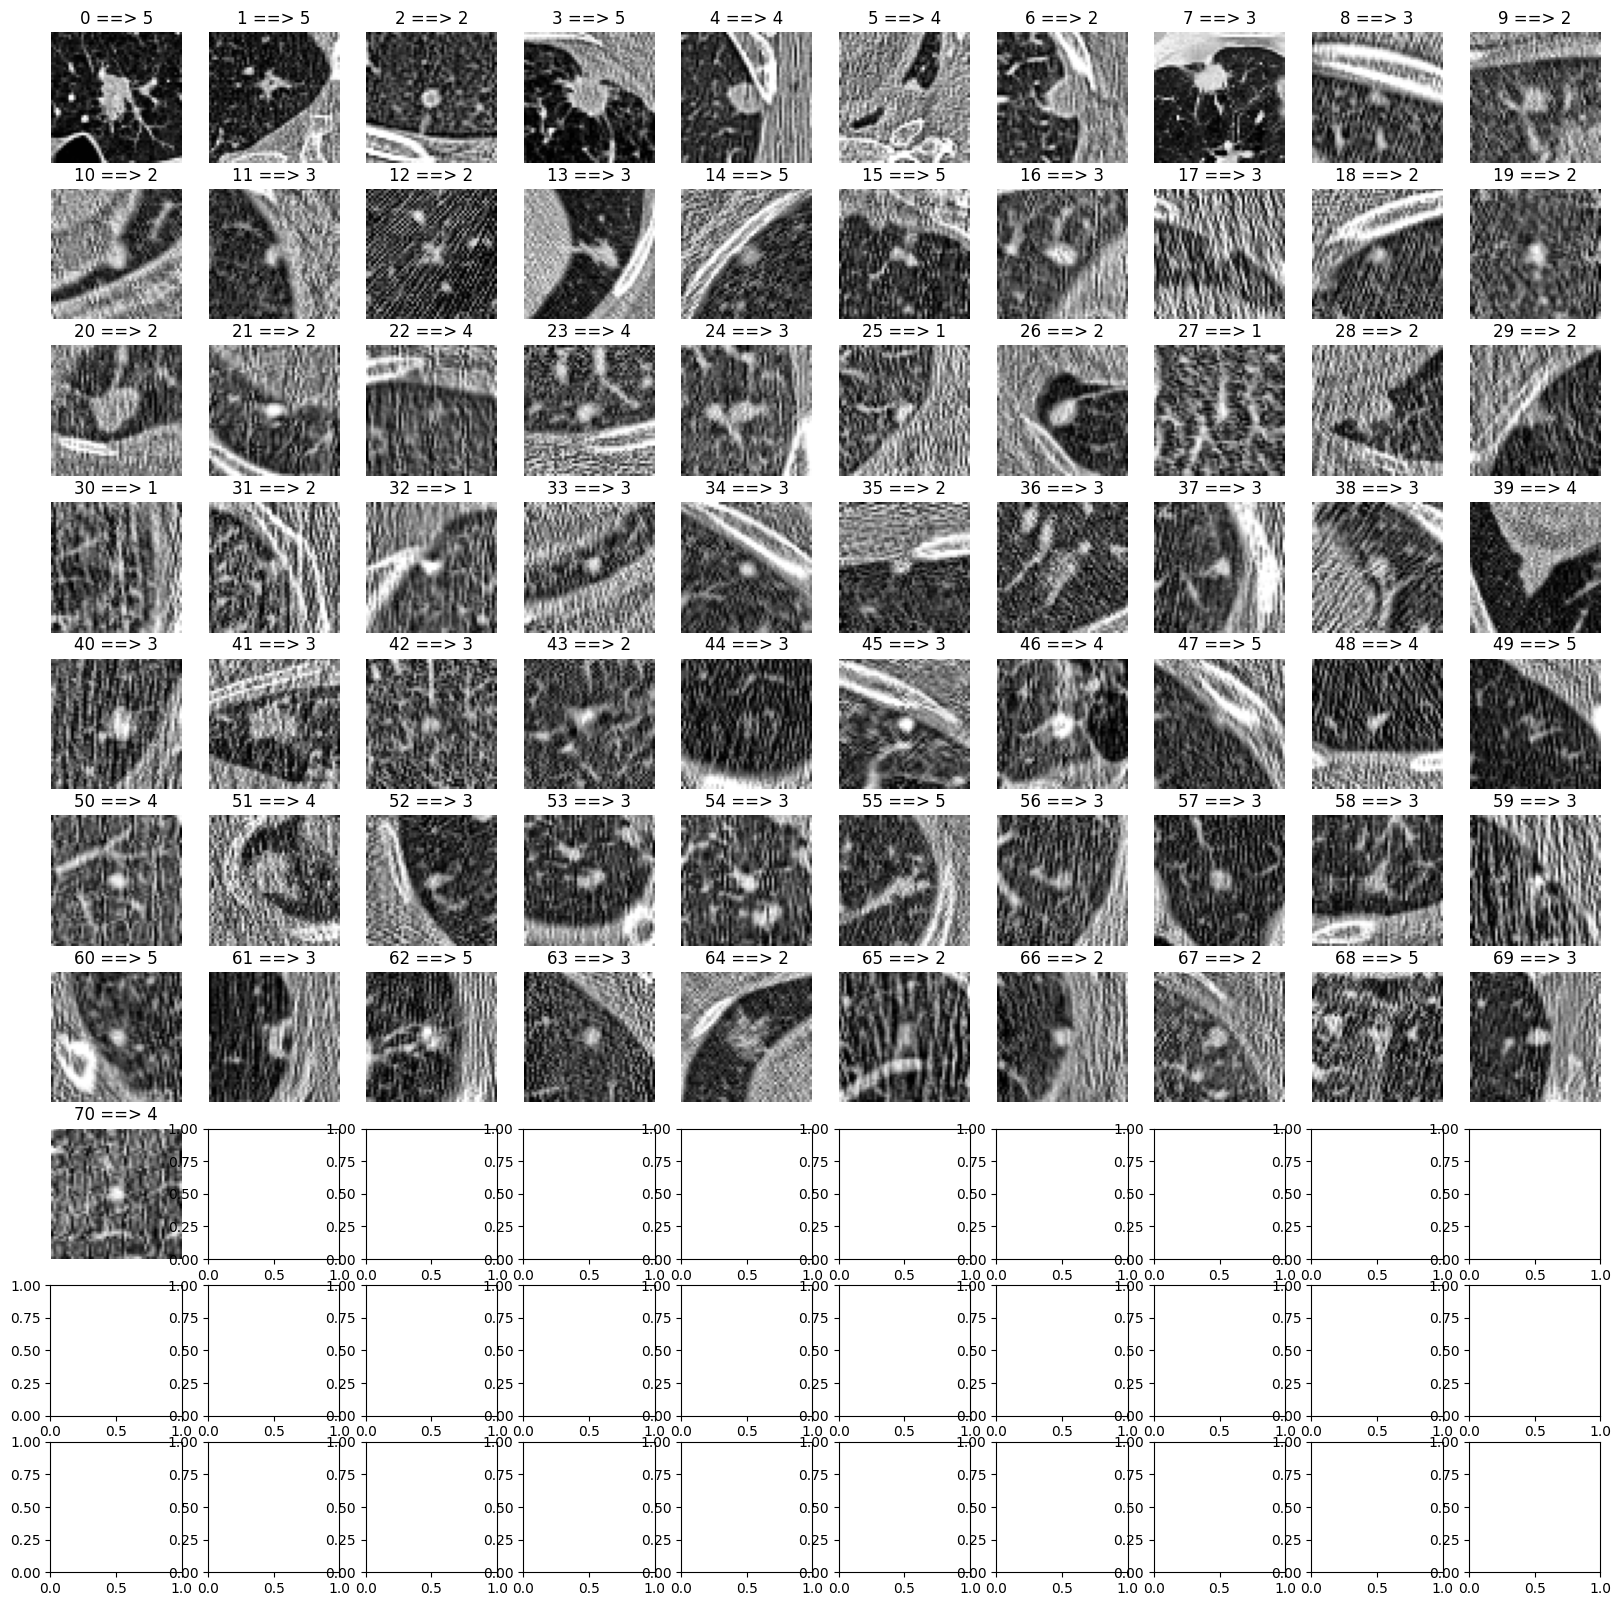

In [21]:
# If you want to see the full slice noisy images run this cell.
# It will raise a list index out of range error but it's OK.
plot_all_images(noise_image_nodule, 0)